In [1]:
import pandas as pd
import numpy as np
from scipy import stats, linalg
from scipy.spatial.transform import Rotation
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FormatStrFormatter
import matplotlib.patches as mpatches
from statannot import add_stat_annotation
import seaborn as sns

import sys
sys.path.append('..')
from plotting import connected_stripplot

%matplotlib inline

---
# Effective dimensionality

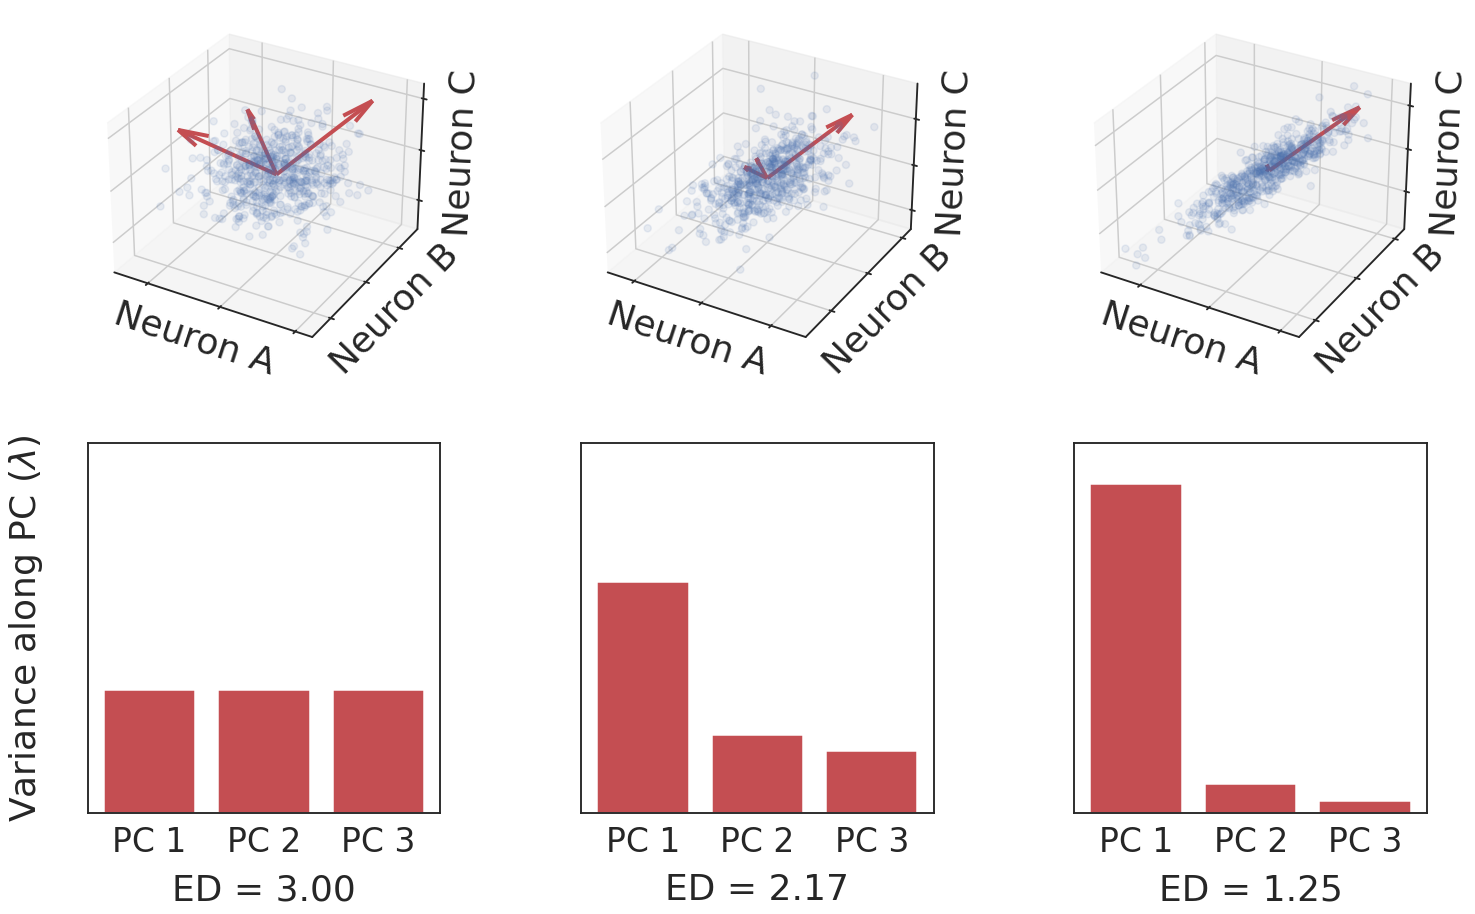

In [2]:
sns.set(style='white', context='talk', font_scale=2)

fig = plt.figure(figsize=(24, 15))
gs = GridSpec(2, 3, wspace=0.4)

gen = np.random.default_rng(seed=27)
n = 600
eigvecs = Rotation.from_euler('ZY', [45, -45], degrees=True).as_matrix()
all_eigvals = np.array([[1, 1, 1,],
                        [1.86846584, 0.63153416, 0.5],
                        [2.66757957, 0.23242043, 0.1]])

for i, eigvals in enumerate(all_eigvals):
    effective_dim = eigvals.sum() ** 2 / (eigvals ** 2).sum()
    samples = gen.multivariate_normal(mean=[0, 0, 0], 
                                      cov=eigvecs @ np.diag(eigvals) @ eigvecs.T, 
                                      size=n)
    
    # Scatterplot
    ax = fig.add_subplot(gs[0, i], projection='3d')
    xs, ys, zs = samples.T
    ax.scatter(xs, ys, zs, 
               alpha=0.1, s=50)
    ax.quiver([0, 0, 0], [0, 0, 0], [0, 0, 0], *(eigvecs * eigvals / eigvals.max()), 
              color=['r', 'r', 'r'], arrow_length_ratio=0.25, length=4, linewidths=4)
    ax.set_xlabel('Neuron A')
    ax.set_ylabel('Neuron B')
    ax.set_zlabel('Neuron C')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    
    # Eigenspectrums
    ax = fig.add_subplot(gs[1, i])
    ax.bar(['PC 1', 'PC 2', 'PC 3'], eigvals, color='r')
    if i == 0:
        ax.set_ylabel(r'Variance along PC ($\lambda$)', labelpad=30)
    else:
        ax.set_ylabel(None)
    ax.set_ylim(0, 3)
    ax.set_yticklabels([])
    ax.set_title(f'ED = {effective_dim:0.2f}', y=-0.25)

plt.savefig('../figures/effective_dimensionality.jpg', dpi=100, bbox_inches='tight')
plt.show()

---
# Main result

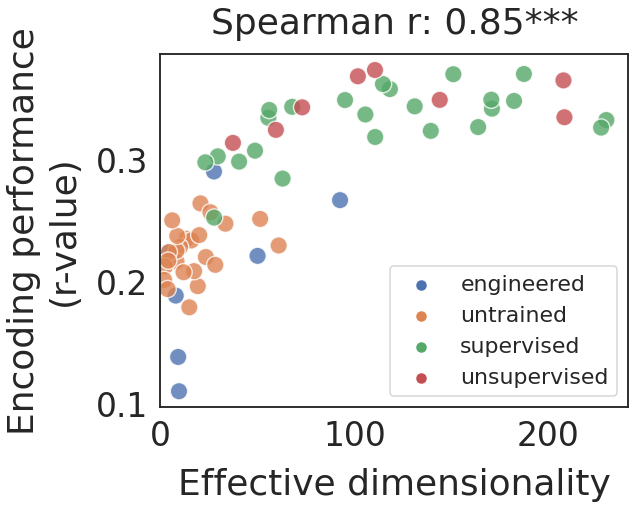

In [5]:
sns.set(style='white', context='talk', font_scale=2, rc={'legend.fontsize': 22})

results = pd.read_csv('../results/object2vec_base_lin.csv')
results = results[~results.model.str.contains('barlow')]
results.loc[results.model.str.contains('untrained'), 'model_type'] = 'untrained'

fig, ax = plt.subplots(figsize=(10, 8))

r, p = stats.spearmanr(results.effective_dimensionality_imagenet, results.score)
sns.scatterplot(x='effective_dimensionality_imagenet', y='score', 
                hue='model_type', hue_order=['engineered', 'untrained', 'supervised', 'unsupervised'],
                data=results, ax=ax,
                alpha=0.8, s=300)
ax.set_xlabel('Effective dimensionality', labelpad=15)
ax.set_ylabel('Encoding performance\n(r-value)', labelpad=15)
ax.set_xlim(0, None)
ax.set_title(f'Spearman r: {r:.2f}***', y=1.04)

ax.legend()

fig.tight_layout()
plt.savefig('../figures/lin_object2vec_base.jpg', dpi=200, bbox_inches='tight')
plt.show()

---
# Across ROIs

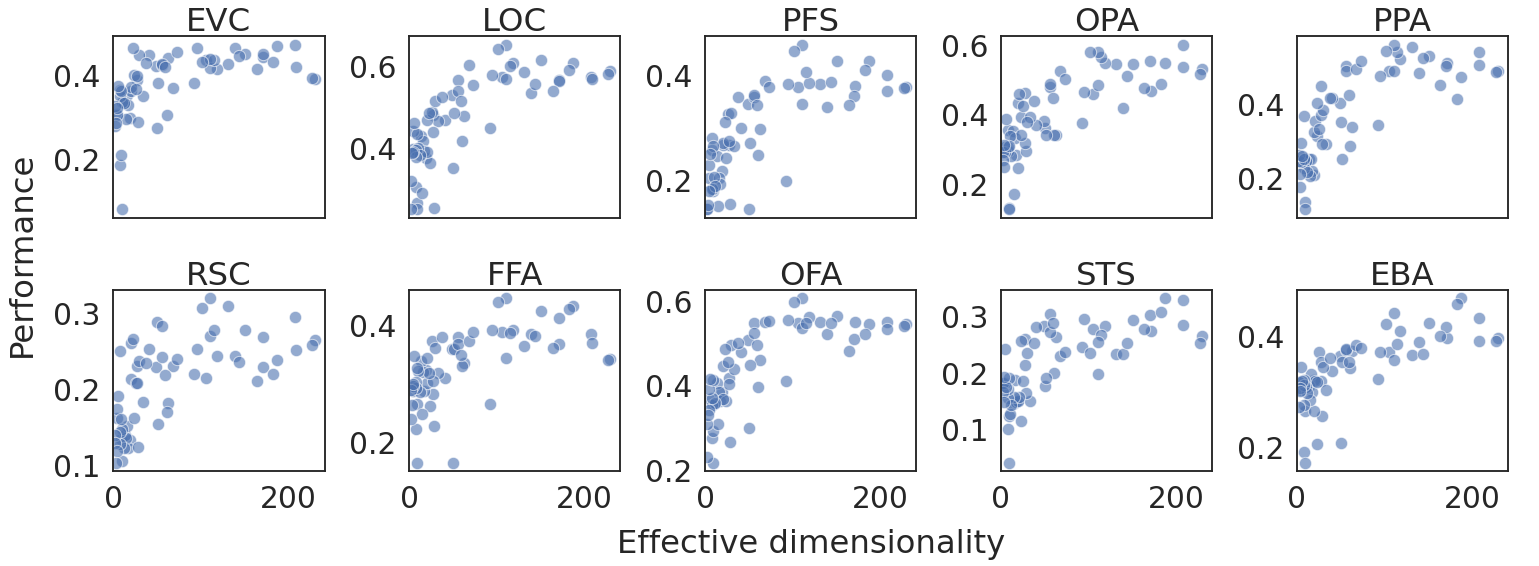

In [97]:
sns.set(style='white', context='talk', font_scale=1.8)

results = pd.read_csv(f'../results/object2vec_rois_base_lin_roiscores.csv')
regions = ['EVC', 'LOC', 'PFS', 'OPA', 'PPA', 'RSC', 'FFA', 'OFA', 'STS', 'EBA']

fig = plt.figure(figsize=(25, 8))
gs = GridSpec(2, 5,hspace=0.4,wspace=0.4)

region_idx = 0
for row in range(2):
    for col in range(5):
        region = regions[region_idx]
        ax = fig.add_subplot(gs[row, col])
        
        sns.scatterplot(x='effective_dimensionality_imagenet', y=region,
                        data=results, ax=ax, 
                        alpha=0.6, s=150)
        
        ax.set_title(region)
        ax.set_xlim(0, None)
        ax.set(xlabel=None, ylabel=None)
        if row == 0:
            ax.set_xticks([])
        
        region_idx += 1
        
fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.xlabel('Effective dimensionality', labelpad=15)
plt.ylabel('Performance', labelpad=15)

plt.savefig('../figures/lin_object2vec_base_rois.jpg', dpi=200, bbox_inches='tight')
plt.show()

---
# Different datasets

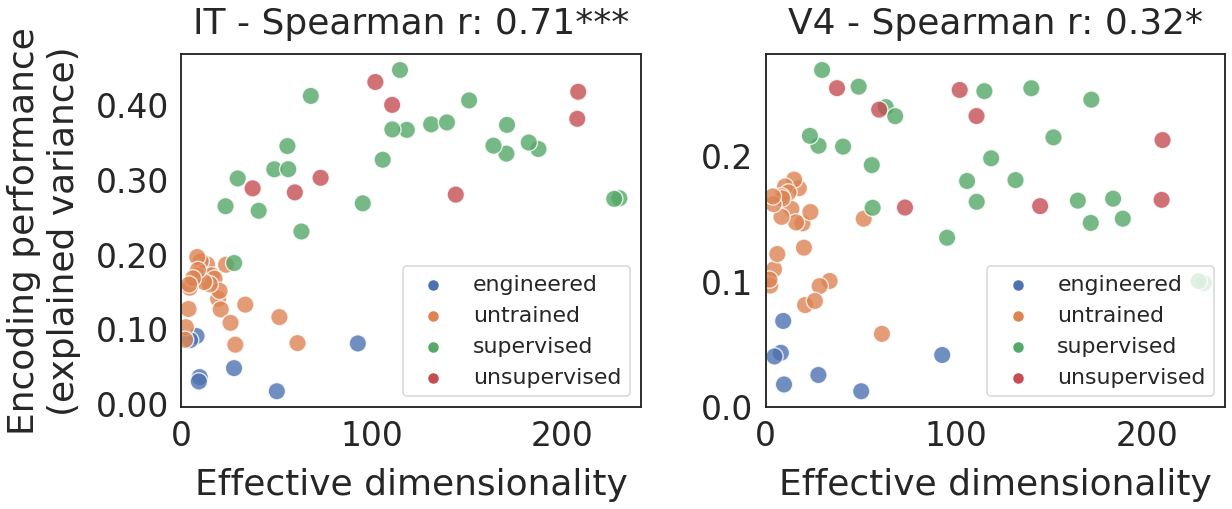

In [78]:
sns.set(style='white', context='talk', font_scale=2, rc={'legend.fontsize': 22})

results = pd.read_csv('../results/majajhong2015_base_lin.csv')
results = results[~results.model.str.contains('barlow')]
results.loc[results.model.str.contains('untrained'), 'model_type'] = 'untrained'

fig, axs = plt.subplots(1, 2, figsize=(18, 8))

roi_results = results[results.region == 'IT']
r, p = stats.spearmanr(roi_results.effective_dimensionality_imagenet, roi_results.score)
sns.scatterplot(x='effective_dimensionality_imagenet', y='score',
                hue='model_type', hue_order=['engineered', 'untrained', 'supervised', 'unsupervised'],
                data=roi_results, ax=axs[0], 
                alpha=0.8, s=300)
axs[0].set_xlabel('Effective dimensionality', labelpad=15)
axs[0].set_ylabel('Encoding performance\n(explained variance)', labelpad=15)
axs[0].set_xlim(0, None)
axs[0].set_title(f'IT - Spearman r: {r:.2f}***', y=1.04)
axs[0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axs[0].legend(loc='lower right')

roi_results = results[results.region == 'V4']
r, p = stats.spearmanr(roi_results.effective_dimensionality_imagenet, roi_results.score)
sns.scatterplot(x='effective_dimensionality_imagenet', y='score',
                hue='model_type', hue_order=['engineered', 'untrained', 'supervised', 'unsupervised'],
                data=roi_results, ax=axs[1], 
                alpha=0.8, s=300)
axs[1].set_xlabel('Effective dimensionality', labelpad=15)
axs[1].set_ylabel(None)
axs[1].set_xlim(0, None)
axs[1].set_title(f'V4 - Spearman r: {r:.2f}*', y=1.04)
axs[1].legend(loc='lower right')

fig.tight_layout()
plt.savefig('../figures/lin_majajhong2015_base.jpg', dpi=200, bbox_inches='tight')
plt.show()

---
# Unsupervised learning models

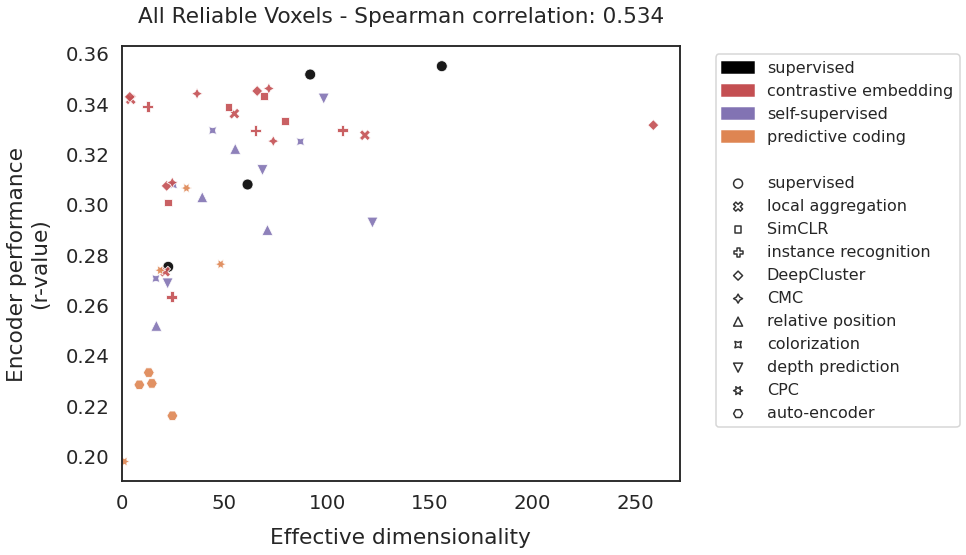

In [7]:
sns.set(style='white', context='talk', font_scale=1.2, rc={'legend.fontsize': 16})

results = pd.read_csv('../results/object2vec_vvs_lin.csv')
results = results[results.model.str.contains('-pool')]

model_map = {'supervised': 'supervised', 'la': 'local aggregation', 'simclr': 'SimCLR', 
             'ir': 'instance recognition', 'deepcluster': 'DeepCluster', 'cmc': 'CMC',
             'rp': 'relative position', 'color': 'colorization', 'depth': 'depth prediction',
             'cpc': 'CPC', 'ae': 'auto-encoder'}
model_map = {f'resnet18-{k}-pool-1000components': v for k, v in model_map.items()}
type_map = {'supervised': 'supervised', 'la': 'contrastive embedding', 'simclr': 'contrastive embedding', 
            'ir': 'contrastive embedding', 'deepcluster': 'contrastive embedding', 'cmc': 'contrastive embedding',
            'rp': 'self-supervised', 'color': 'self-supervised', 'depth': 'self-supervised',
            'cpc': 'predictive coding', 'ae': 'predictive coding'}
type_map = {f'resnet18-{k}-pool-1000components': v for k, v in type_map.items()}
results['type'] = results.model.map(type_map)
results['model'] = results.model.replace(model_map)

fig, ax = plt.subplots(figsize=(10, 8))

r, _ = stats.spearmanr(results.effective_dimensionality_imagenet, results.score)
sns.scatterplot(x='effective_dimensionality_imagenet', y='score', 
                hue='type', hue_order=['supervised', 'contrastive embedding', 'self-supervised', 'predictive coding'], 
                style='model', style_order=model_map.values(),
                data=results, ax=ax, 
                alpha=0.8, s=120, 
                palette=[(0, 0, 0), (0.77, 0.31, 0.32), (0.51, 0.45, 0.70), (0.87, 0.52, 0.32)])
ax.set_xlabel('Effective dimensionality', labelpad=15)
ax.set_ylabel('Encoding performance\n(r-value)', labelpad=15)
ax.set_xlim(0, None)
ax.set_title(f'All Reliable Voxels - Spearman r: {r:.3f}', y=1.04)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

handles, labels = ax.get_legend_handles_labels()
hue_handles, hue_labels = handles[1:5], labels[1:5]
hue_handles = [mpatches.Patch(color=p.get_facecolor()[0]) for p in hue_handles]
style_handles, style_labels = handles[5:], labels[5:]
style_labels[0] = ''
for h in style_handles[1:]:
    h.set_facecolors('none')
legend = ax.legend(hue_handles + style_handles, hue_labels + style_labels, bbox_to_anchor=(1.05, 1))

plt.savefig('../figures/lin_object2vec_vvs.jpg', dpi=200, bbox_inches='tight')
plt.show()

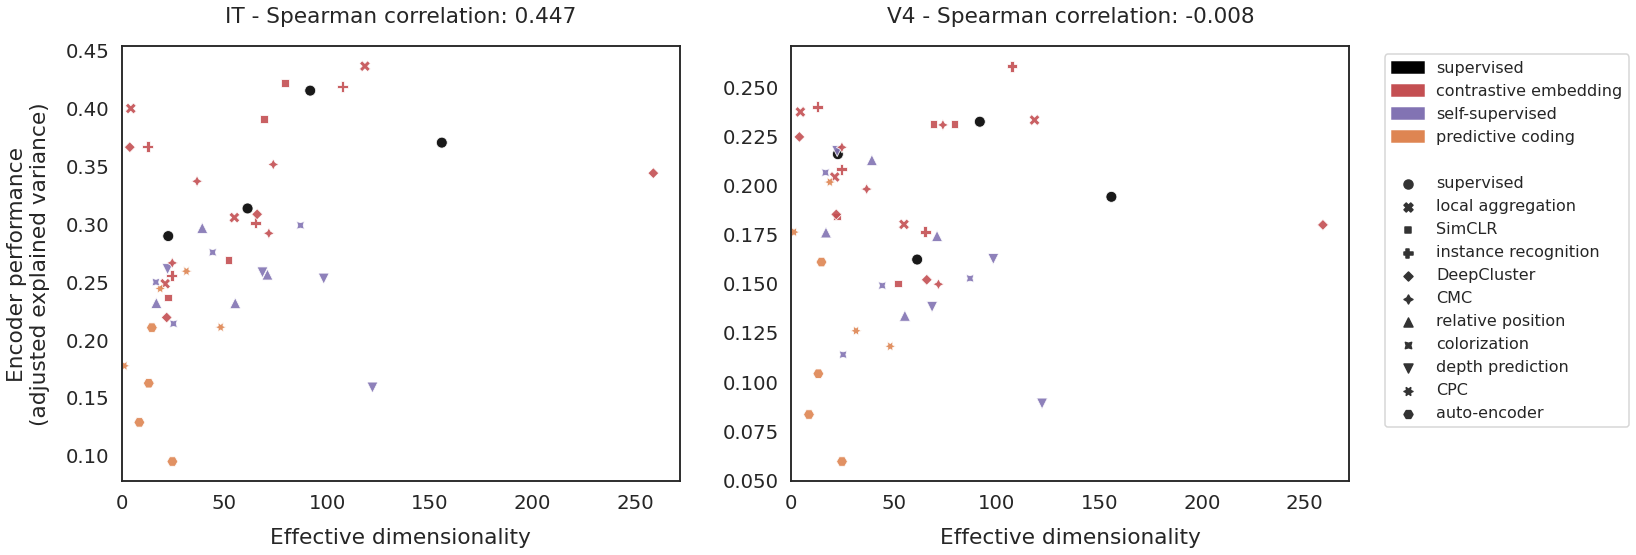

In [8]:
sns.set(style='white', context='talk', font_scale=1.2, rc={'legend.fontsize': 16})

results = pd.read_csv('../results/majajhong2015_vvs_lin.csv')
results = results[results.model.str.contains('-pool')]

model_map = {'supervised': 'supervised', 'la': 'local aggregation', 'simclr': 'SimCLR', 
             'ir': 'instance recognition', 'deepcluster': 'DeepCluster', 'cmc': 'CMC',
             'rp': 'relative position', 'color': 'colorization', 'depth': 'depth prediction',
             'cpc': 'CPC', 'ae': 'auto-encoder'}
model_map = {f'resnet18-{k}-pool-1000components': v for k, v in model_map.items()}
type_map = {'supervised': 'supervised', 'la': 'contrastive embedding', 'simclr': 'contrastive embedding', 
            'ir': 'contrastive embedding', 'deepcluster': 'contrastive embedding', 'cmc': 'contrastive embedding',
            'rp': 'self-supervised', 'color': 'self-supervised', 'depth': 'self-supervised',
            'cpc': 'predictive coding', 'ae': 'predictive coding'}
type_map = {f'resnet18-{k}-pool-1000components': v for k, v in type_map.items()}
results['type'] = results.model.map(type_map)
results['model'] = results.model.replace(model_map)

fig, axs = plt.subplots(1, 2, figsize=(22, 8))

roi_results = results[results.region == 'IT']
r, _ = stats.spearmanr(roi_results.effective_dimensionality_imagenet, roi_results.score)
sns.scatterplot(x='effective_dimensionality_imagenet', y='score', 
                hue='type', hue_order=['supervised', 'contrastive embedding', 'self-supervised', 'predictive coding'], 
                style='model', style_order=model_map.values(),
                data=roi_results, ax=axs[0], 
                alpha=0.8, s=120, 
                palette=[(0, 0, 0), (0.77, 0.31, 0.32), (0.51, 0.45, 0.70), (0.87, 0.52, 0.32)])
axs[0].set_xlabel('Effective dimensionality', labelpad=15)
axs[0].set_ylabel('Encoding performance\n(adjusted explained variance)', labelpad=15)
axs[0].set_xlim(0, None)
axs[0].set_title(f'IT - Spearman r: {r:.3f}', y=1.04)
axs[0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axs[0].legend().remove()

roi_results = results[results.region == 'V4']
r, _ = stats.spearmanr(roi_results.effective_dimensionality_imagenet, roi_results.score)
sns.scatterplot(x='effective_dimensionality_imagenet', y='score', 
                hue='type', hue_order=['supervised', 'contrastive embedding', 'self-supervised', 'predictive coding'], 
                style='model', style_order=model_map.values(),
                data=roi_results, ax=axs[1], 
                alpha=0.8, s=120, 
                palette=[(0, 0, 0), (0.77, 0.31, 0.32), (0.51, 0.45, 0.70), (0.87, 0.52, 0.32)])
axs[1].set_xlabel('Effective dimensionality', labelpad=15)
axs[1].set_ylabel(None)
axs[1].set_xlim(0, None)
axs[1].set_title(f'V4 - Spearman r: {r:.3f}', y=1.04)

handles, labels = axs[1].get_legend_handles_labels()
hue_handles, hue_labels = handles[1:5], labels[1:5]
hue_handles = [mpatches.Patch(color=p.get_facecolor()[0]) for p in hue_handles]
style_handles, style_labels = handles[5:], labels[5:]
style_labels[0] = ''
legend = axs[1].legend(hue_handles + style_handles, hue_labels + style_labels, bbox_to_anchor=(1.05, 1))

plt.savefig('../figures/lin_majajhong2015_vvs.jpg', dpi=200, bbox_inches='tight')
plt.show()

---
# Partial Least Squares regression

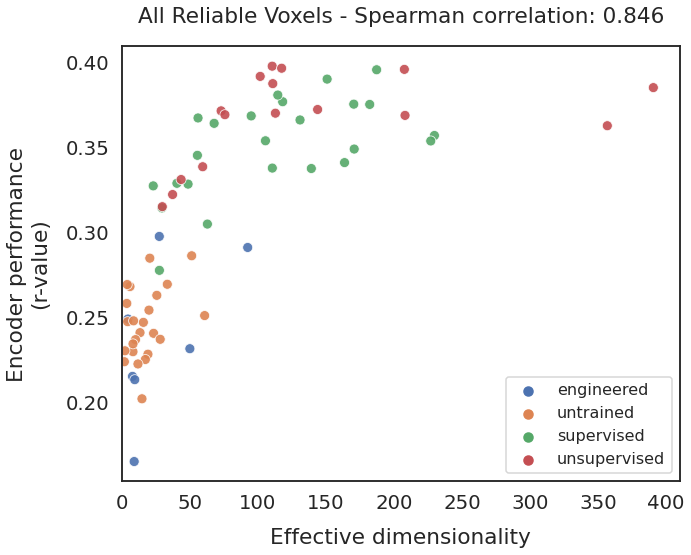

In [9]:
sns.set(style='white', context='talk', font_scale=1.2, rc={'legend.fontsize': 16})

results = pd.read_csv('../results/object2vec_base_pls.csv')
results.loc[results.model.str.contains('untrained'), 'model_type'] = 'untrained'

fig, ax = plt.subplots(figsize=(10, 8))

r, _ = stats.spearmanr(results.effective_dimensionality_imagenet, results.score)
sns.scatterplot(x='effective_dimensionality_imagenet', y='score',
                hue='model_type', hue_order=['engineered', 'untrained', 'supervised', 'unsupervised'],
                data=results, ax=ax, 
                alpha=0.8, s=100)
ax.set_xlabel('Effective dimensionality', labelpad=15)
ax.set_ylabel('Encoding performance\n(r-value)', labelpad=15)
ax.set_xlim(0, None)
ax.set_title(f'All Reliable Voxels - Spearman r: {r:.3f}', y=1.04)

ax.legend()

plt.savefig('../figures/pls_object2vec_base.jpg', dpi=200, bbox_inches='tight')
plt.show()

---
# RSA

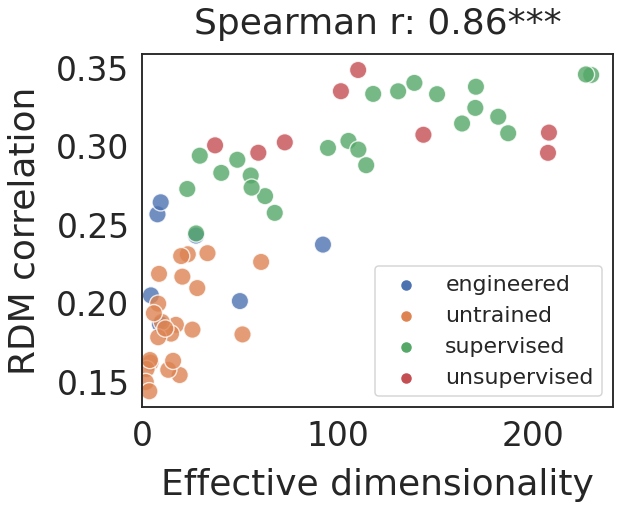

In [31]:
sns.set(style='white', context='talk', font_scale=2, rc={'legend.fontsize': 22})

results = pd.read_csv('../results/object2vec_base_rsa.csv')
results = results[~results.model.str.contains('barlow')]
results.loc[results.model.str.contains('untrained'), 'model_type'] = 'untrained'

fig, ax = plt.subplots(figsize=(9.5, 8))

r, p = stats.spearmanr(results.effective_dimensionality_imagenet, results.score)
sns.scatterplot(x='effective_dimensionality_imagenet', y='score',
                hue='model_type', hue_order=['engineered', 'untrained', 'supervised', 'unsupervised'],
                data=results, ax=ax, 
                alpha=0.8, s=300)
ax.set_xlabel('Effective dimensionality', labelpad=15)
ax.set_ylabel('RDM correlation', labelpad=15)
ax.set_xlim(0, None)
ax.set_title(f'Spearman r: {r:.2f}***', y=1.04)

ax.legend(loc='lower right')

fig.tight_layout()
plt.savefig('../figures/rsa_object2vec_base.jpg', dpi=200, bbox_inches='tight')
plt.show()

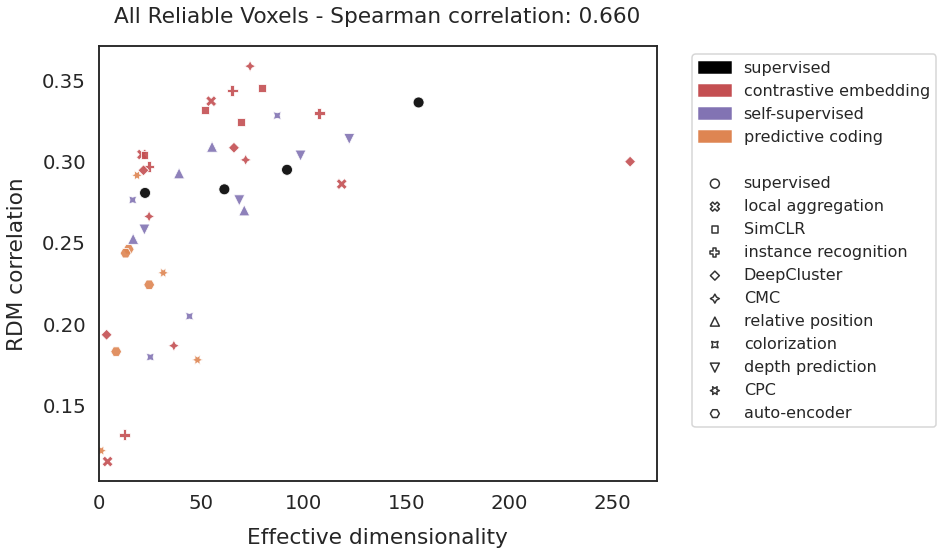

In [11]:
sns.set(style='white', context='talk', font_scale=1.2, rc={'legend.fontsize': 16})

results = pd.read_csv('../results/object2vec_vvs_rsa.csv')
results = results[results.model.str.contains('-pool')]

model_map = {'supervised': 'supervised', 'la': 'local aggregation', 'simclr': 'SimCLR', 
             'ir': 'instance recognition', 'deepcluster': 'DeepCluster', 'cmc': 'CMC',
             'rp': 'relative position', 'color': 'colorization', 'depth': 'depth prediction',
             'cpc': 'CPC', 'ae': 'auto-encoder'}
model_map = {f'resnet18-{k}-pool-1000components': v for k, v in model_map.items()}
type_map = {'supervised': 'supervised', 'la': 'contrastive embedding', 'simclr': 'contrastive embedding', 
            'ir': 'contrastive embedding', 'deepcluster': 'contrastive embedding', 'cmc': 'contrastive embedding',
            'rp': 'self-supervised', 'color': 'self-supervised', 'depth': 'self-supervised',
            'cpc': 'predictive coding', 'ae': 'predictive coding'}
type_map = {f'resnet18-{k}-pool-1000components': v for k, v in type_map.items()}
results['type'] = results.model.map(type_map)
results['model'] = results.model.replace(model_map)

fig, ax = plt.subplots(figsize=(10, 8))

r, _ = stats.spearmanr(results.effective_dimensionality_imagenet, results.score)
sns.scatterplot(x='effective_dimensionality_imagenet', y='score', 
                hue='type', hue_order=['supervised', 'contrastive embedding', 'self-supervised', 'predictive coding'], 
                style='model', style_order=model_map.values(),
                data=results, ax=ax, 
                alpha=0.8, s=120, 
                palette=[(0, 0, 0), (0.77, 0.31, 0.32), (0.51, 0.45, 0.70), (0.87, 0.52, 0.32)])
ax.set_xlabel('Effective dimensionality', labelpad=15)
ax.set_ylabel('RDM correlation', labelpad=15)
ax.set_xlim(0, None)
ax.set_title(f'All Reliable Voxels - Spearman r: {r:.3f}', y=1.04)

handles, labels = ax.get_legend_handles_labels()
hue_handles, hue_labels = handles[1:5], labels[1:5]
hue_handles = [mpatches.Patch(color=p.get_facecolor()[0]) for p in hue_handles]
style_handles, style_labels = handles[5:], labels[5:]
style_labels[0] = ''
for h in style_handles[1:]:
    h.set_facecolors('none')
legend = ax.legend(hue_handles + style_handles, hue_labels + style_labels, bbox_to_anchor=(1.05, 1))

plt.savefig('../figures/rsa_object2vec_vvs.jpg', dpi=200, bbox_inches='tight')
plt.show()

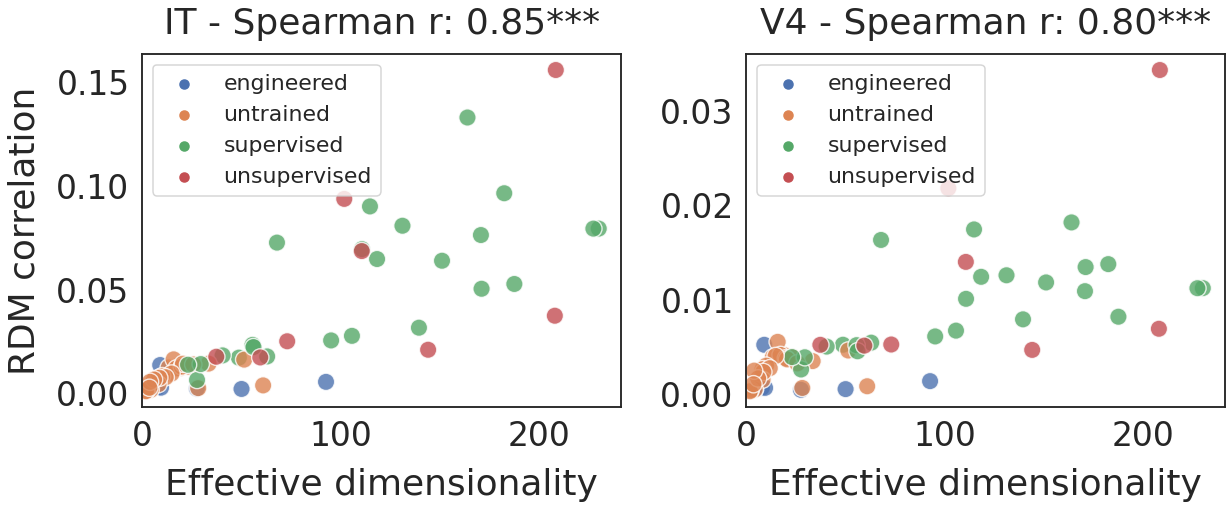

In [125]:
sns.set(style='white', context='talk', font_scale=2, rc={'legend.fontsize': 22})

results = pd.read_csv('../results/majajhong2015_base_rsa.csv')
results = results[~results.model.str.contains('barlow')]
results.loc[results.model.str.contains('untrained'), 'model_type'] = 'untrained'

fig, axs = plt.subplots(1, 2, figsize=(18, 8))

roi_results = results[results.region == 'IT']
r, p = stats.spearmanr(roi_results.effective_dimensionality_imagenet, roi_results.score)
sns.scatterplot(x='effective_dimensionality_imagenet', y='score',
                hue='model_type', hue_order=['engineered', 'untrained', 'supervised', 'unsupervised'],
                data=roi_results, ax=axs[0], 
                alpha=0.8, s=300)
axs[0].set_xlabel('Effective dimensionality', labelpad=15)
axs[0].set_ylabel('RDM correlation', labelpad=15)
axs[0].set_xlim(0, None)
axs[0].set_title(f'IT - Spearman r: {r:.2f}***', y=1.04)
axs[0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axs[0].legend()

roi_results = results[results.region == 'V4']
r, p = stats.spearmanr(roi_results.effective_dimensionality_imagenet, roi_results.score)
sns.scatterplot(x='effective_dimensionality_imagenet', y='score',
                hue='model_type', hue_order=['engineered', 'untrained', 'supervised', 'unsupervised'],
                data=roi_results, ax=axs[1], 
                alpha=0.8, s=300)
axs[1].set_xlabel('Effective dimensionality', labelpad=15)
axs[1].set_ylabel(None)
axs[1].set_xlim(0, None)
axs[1].set_title(f'V4 - Spearman r: {r:.2f}***', y=1.04)
axs[1].legend(loc='upper left')

fig.tight_layout()
plt.savefig('../figures/rsa_majajhong2015_base.jpg', dpi=200, bbox_inches='tight')
plt.show()

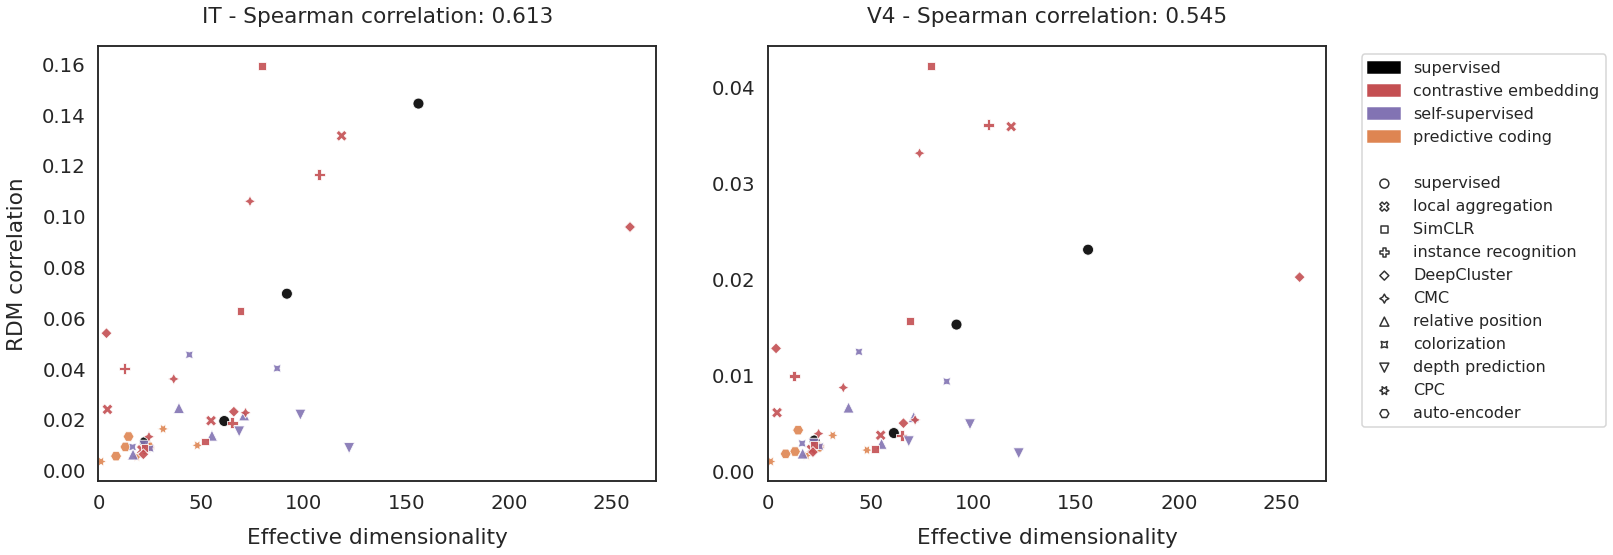

In [13]:
sns.set(style='white', context='talk', font_scale=1.2, rc={'legend.fontsize': 16})

results = pd.read_csv('../results/majajhong2015_vvs_rsa.csv')
results = results[results.model.str.contains('-pool')]

model_map = {'supervised': 'supervised', 'la': 'local aggregation', 'simclr': 'SimCLR', 
             'ir': 'instance recognition', 'deepcluster': 'DeepCluster', 'cmc': 'CMC',
             'rp': 'relative position', 'color': 'colorization', 'depth': 'depth prediction',
             'cpc': 'CPC', 'ae': 'auto-encoder'}
model_map = {f'resnet18-{k}-pool-1000components': v for k, v in model_map.items()}
type_map = {'supervised': 'supervised', 'la': 'contrastive embedding', 'simclr': 'contrastive embedding', 
            'ir': 'contrastive embedding', 'deepcluster': 'contrastive embedding', 'cmc': 'contrastive embedding',
            'rp': 'self-supervised', 'color': 'self-supervised', 'depth': 'self-supervised',
            'cpc': 'predictive coding', 'ae': 'predictive coding'}
type_map = {f'resnet18-{k}-pool-1000components': v for k, v in type_map.items()}
results['type'] = results.model.map(type_map)
results['model'] = results.model.replace(model_map)

fig, axs = plt.subplots(1, 2, figsize=(22, 8))

roi_results = results[results.region == 'IT']
r, _ = stats.spearmanr(roi_results.effective_dimensionality_imagenet, roi_results.score)
sns.scatterplot(x='effective_dimensionality_imagenet', y='score', 
                hue='type', hue_order=['supervised', 'contrastive embedding', 'self-supervised', 'predictive coding'], 
                style='model', style_order=model_map.values(),
                data=roi_results, ax=axs[0], 
                alpha=0.8, s=120, 
                palette=[(0, 0, 0), (0.77, 0.31, 0.32), (0.51, 0.45, 0.70), (0.87, 0.52, 0.32)])
axs[0].set_xlabel('Effective dimensionality', labelpad=15)
axs[0].set_ylabel('RDM correlation', labelpad=15)
axs[0].set_xlim(0, None)
axs[0].set_title(f'IT - Spearman r: {r:.3f}', y=1.04)
axs[0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axs[0].legend().remove()

roi_results = results[results.region == 'V4']
r, _ = stats.spearmanr(roi_results.effective_dimensionality_imagenet, roi_results.score)
sns.scatterplot(x='effective_dimensionality_imagenet', y='score', 
                hue='type', hue_order=['supervised', 'contrastive embedding', 'self-supervised', 'predictive coding'], 
                style='model', style_order=model_map.values(),
                data=roi_results, ax=axs[1], 
                alpha=0.8, s=120, 
                palette=[(0, 0, 0), (0.77, 0.31, 0.32), (0.51, 0.45, 0.70), (0.87, 0.52, 0.32)])
axs[1].set_xlabel('Effective dimensionality', labelpad=15)
axs[1].set_ylabel(None)
axs[1].set_xlim(0, None)
axs[1].set_title(f'V4 - Spearman r: {r:.3f}', y=1.04)

handles, labels = axs[1].get_legend_handles_labels()
hue_handles, hue_labels = handles[1:5], labels[1:5]
hue_handles = [mpatches.Patch(color=p.get_facecolor()[0]) for p in hue_handles]
style_handles, style_labels = handles[5:], labels[5:]
style_labels[0] = ''
for h in style_handles[1:]:
    h.set_facecolors('none')
legend = axs[1].legend(hue_handles + style_handles, hue_labels + style_labels, bbox_to_anchor=(1.05, 1))

plt.savefig('../figures/rsa_majajhong2015_vvs.jpg', dpi=200, bbox_inches='tight')
plt.show()

---
# Z-scoring

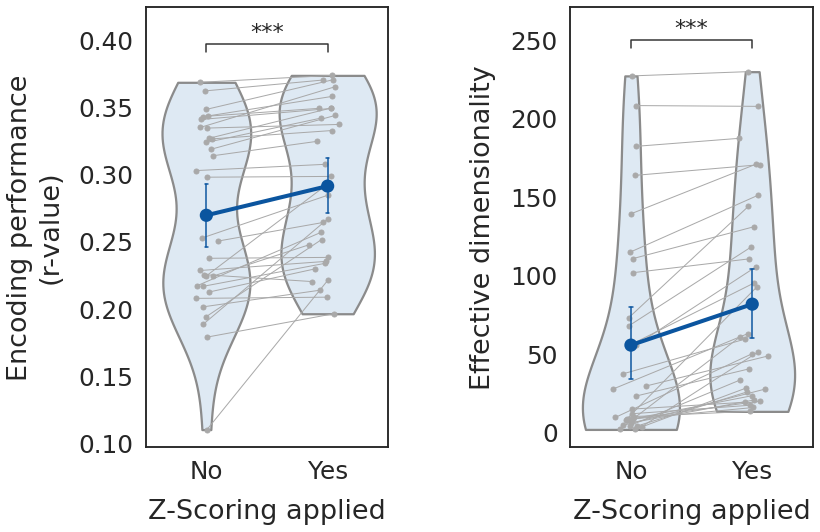

In [40]:
sns.set(style='white', context='talk', font_scale=1.5, rc={'legend.fontsize': 22})

results = pd.read_csv('../results/object2vec_base_lin.csv')
results = results[~results.model.str.contains('barlow')]
results.loc[results.model.str.contains('untrained'), 'model_type'] = 'untrained'

results = results[~results.model.str.contains('pixels')]
results['zscore'] = results.model.apply(lambda x: 'Yes' if '-zscore' in x else 'No')
results['group'] = results.model.str.replace('-zscore', '') + results.layer

fig, axs = plt.subplots(1, 2, figsize=(12, 8))

connected_stripplot(data=results, x='zscore', y='score', group_id='group',
                    xorder=['No', 'Yes'], ax=axs[0], line_kwargs={'linewidth': 1})
results_pivot = results.pivot(index='group', columns='zscore', values='score')
t, p = stats.ttest_rel(results_pivot['Yes'], results_pivot['No'])
add_stat_annotation(axs[0], data=results, x='zscore', y='score', order=['No', 'Yes'],
                    box_pairs=[('No', 'Yes')], pvalues=[p], perform_stat_test=False, 
                    pvalue_thresholds=[[5e-4, "***"], [5e-3, "**"], 
                                       [0.025, "*"], [1, "ns"]], 
                    fontsize='small', verbose=0)
axs[0].set_xlabel('Z-Scoring applied', labelpad=15)
axs[0].set_ylabel('Encoding performance\n(r-value)', labelpad=15)

connected_stripplot(data=results, x='zscore', y='effective_dimensionality_imagenet', group_id='group',
                    xorder=['No', 'Yes'], ax=axs[1], line_kwargs={'linewidth': 1})
results_pivot = results.pivot(index='group', columns='zscore', values='effective_dimensionality_imagenet')
t, p = stats.ttest_rel(results_pivot['Yes'], results_pivot['No'])
add_stat_annotation(axs[1], data=results, x='zscore', y='effective_dimensionality_imagenet', order=['No', 'Yes'],
                    box_pairs=[('No', 'Yes')], pvalues=[p], perform_stat_test=False, 
                    pvalue_thresholds=[[5e-4, "***"], [5e-3, "**"], 
                                       [0.025, "*"], [1, "ns"]], 
                    fontsize='small', verbose=0)
axs[1].set_xlabel('Z-Scoring applied', labelpad=15)
axs[1].set_ylabel('Effective dimensionality', labelpad=15)

fig.tight_layout()
fig.subplots_adjust(wspace=0.75)
plt.show()

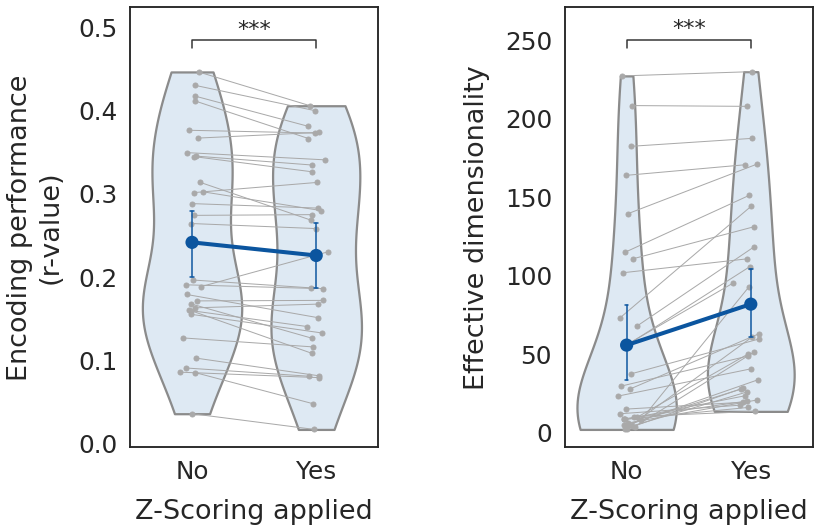

In [43]:
sns.set(style='white', context='talk', font_scale=1.5, rc={'legend.fontsize': 22})

results = pd.read_csv('../results/majajhong2015_base_lin.csv')
results = results[results.region == 'IT']
results = results[~results.model.str.contains('barlow')]
results.loc[results.model.str.contains('untrained'), 'model_type'] = 'untrained'

results = results[~results.model.str.contains('pixels')]
results['zscore'] = results.model.apply(lambda x: 'Yes' if '-zscore' in x else 'No')
results['group'] = results.model.str.replace('-zscore', '') + results.layer

fig, axs = plt.subplots(1, 2, figsize=(12, 8))

connected_stripplot(data=results, x='zscore', y='score', group_id='group',
                    xorder=['No', 'Yes'], ax=axs[0], line_kwargs={'linewidth': 1})
results_pivot = results.pivot(index='group', columns='zscore', values='score')
t, p = stats.ttest_rel(results_pivot['Yes'], results_pivot['No'])
add_stat_annotation(axs[0], data=results, x='zscore', y='score', order=['No', 'Yes'],
                    box_pairs=[('No', 'Yes')], pvalues=[p], perform_stat_test=False, 
                    pvalue_thresholds=[[5e-4, "***"], [5e-3, "**"], 
                                       [0.025, "*"], [1, "ns"]], 
                    fontsize='small', verbose=0)
axs[0].set_xlabel('Z-Scoring applied', labelpad=15)
axs[0].set_ylabel('Encoding performance\n(r-value)', labelpad=15)

connected_stripplot(data=results, x='zscore', y='effective_dimensionality_imagenet', group_id='group',
                    xorder=['No', 'Yes'], ax=axs[1], line_kwargs={'linewidth': 1})
results_pivot = results.pivot(index='group', columns='zscore', values='effective_dimensionality_imagenet')
t, p = stats.ttest_rel(results_pivot['Yes'], results_pivot['No'])
add_stat_annotation(axs[1], data=results, x='zscore', y='effective_dimensionality_imagenet', order=['No', 'Yes'],
                    box_pairs=[('No', 'Yes')], pvalues=[p], perform_stat_test=False, 
                    pvalue_thresholds=[[5e-4, "***"], [5e-3, "**"], 
                                       [0.025, "*"], [1, "ns"]], 
                    fontsize='small', verbose=0)
axs[1].set_xlabel('Z-Scoring applied', labelpad=15)
axs[1].set_ylabel('Effective dimensionality', labelpad=15)

fig.tight_layout()
fig.subplots_adjust(wspace=0.75)
plt.show()

---
# Barlow Twins

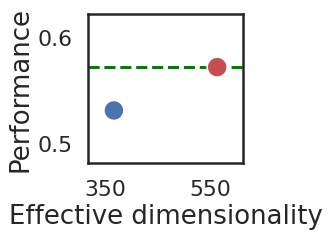

In [81]:
sns.set(style='white', context='poster', rc={'axes.labelsize': 26})

fig, ax = plt.subplots(figsize=(4, 3.7))

sns.scatterplot(x=[563, 366], y=[0.572, 0.531], ax=ax, s=400, c=[sns.color_palette()[3], sns.color_palette()[0]])
plt.setp(ax.lines, zorder=100)
plt.setp(ax.collections, zorder=100, label="")
ax.hlines(0.572, 366-50, 563+50, linestyles='--', color='green')
ax.set_xlim(366 - 50, 563 + 50)
ax.set_ylim(0.531 - 0.05, 0.572 + 0.05)
ax.set_xlabel('Effective dimensionality')
ax.set_ylabel('Performance')
ax.set_xticks([350, 550])
ax.set_yticks([0.5, 0.6])

fig.tight_layout()
plt.savefig('../figures/barlow_twins_performance.jpg', dpi=200, bbox_inches='tight')
plt.show()

---
# Partial correlation analysis

In [83]:
results = pd.read_csv('../results/object2vec_base_lin.csv')

def partial_corr(C, corr_func=stats.pearsonr):
    """
    Returns the sample linear partial correlation coefficients between pairs of variables in C, controlling 
    for the remaining variables in C.
    Parameters
    ----------
    C : array-like, shape (n, p)
        Array with the different variables. Each column of C is taken as a variable
    Returns
    -------
    P : array-like, shape (p, p)
        P[i, j] contains the partial correlation of C[:, i] and C[:, j] controlling
        for the remaining variables in C.
    """

    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=np.float32)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            beta_j = linalg.lstsq(C[:, idx], C[:, i])[0]

            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] - C[:, idx].dot(beta_j)

            corr = corr_func(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr

    return P_corr

In [84]:
print('AlexNet models')
C = results[results.model.str.contains('base=alexnet')]
C = C[['layer', 'effective_dimensionality_imagenet', 'score']]
C.loc[:, 'layer'] = C.layer.apply(lambda x: float(x[-1]))
pcorr = partial_corr(C.values, corr_func=stats.spearmanr)
pd.DataFrame(pcorr, index=['Layer', 'ED', 'Performance'], columns=['Layer', 'ED', 'Performance'])

AlexNet models


,Layer,ED,Performance
Layer,1.000000,-0.052941,0.688235
ED,-0.052941,1.000000,0.529412
Performance,0.688235,0.529412,1.000000


In [85]:
print('ResNet models')
C = results[results.model.str.contains('base=resnet')]
C = C[['layer', 'effective_dimensionality_imagenet', 'score']]
C.loc[:, 'layer'] = C.layer.apply(lambda x: float(x[-1]))
pcorr = partial_corr(C.values, corr_func=stats.spearmanr)
pd.DataFrame(pcorr, index=['Layer', 'ED', 'Performance'], columns=['Layer', 'ED', 'Performance'])

ResNet models


,Layer,ED,Performance
Layer,1.000000,0.381785,0.262484
ED,0.381785,1.000000,0.278875
Performance,0.262484,0.278875,1.000000


In [86]:
print('ResNet 50 models')
C = results[results.model.str.contains('base=resnet50')]
C = C[['layer', 'effective_dimensionality_imagenet', 'score']]
C.loc[:, 'layer'] = C.layer.apply(lambda x: float(x[-1]))
pcorr = partial_corr(C.values, corr_func=stats.spearmanr)
pd.DataFrame(pcorr, index=['Layer', 'ED', 'Performance'], columns=['Layer', 'ED', 'Performance'])

ResNet 50 models


,Layer,ED,Performance
Layer,1.000000,0.451613,0.187317
ED,0.451613,1.000000,0.227273
Performance,0.187317,0.227273,1.000000


In [87]:
print('ResNet 18 models')
C = results[results.model.str.contains('base=resnet18')]
C = C[['layer', 'effective_dimensionality_imagenet', 'score']]
C.loc[:, 'layer'] = C.layer.apply(lambda x: float(x[-1]))
pcorr = partial_corr(C.values, corr_func=stats.spearmanr)
pd.DataFrame(pcorr, index=['Layer', 'ED', 'Performance'], columns=['Layer', 'ED', 'Performance'])

ResNet 18 models


,Layer,ED,Performance
Layer,1.000000,0.238235,0.591176
ED,0.238235,1.000000,0.388235
Performance,0.591176,0.388235,1.000000


In [88]:
print('AlexNet models')
C = results[results.model.str.contains('base=alexnet')]
C = C.assign(trained=(~C.model.str.contains('untrained')).astype(float))
C = C[['layer', 'effective_dimensionality_imagenet', 'trained', 'score']]
C.loc[:, 'layer'] = C.layer.apply(lambda x: float(x[-1]))
pcorr = partial_corr(C.values, corr_func=stats.spearmanr)
pd.DataFrame(pcorr, index=['Layer', 'ED', 'Trained', 'Performance'], columns=['Layer', 'ED', 'Trained', 'Performance'])

AlexNet models


,Layer,ED,Trained,Performance
Layer,1.000000,0.200000,-0.511765,0.794118
ED,0.200000,1.000000,0.667647,0.070588
Trained,-0.511765,0.667647,1.000000,0.308824
Performance,0.794118,0.070588,0.308824,1.000000


In [89]:
print('ResNet models')
C = results[results.model.str.contains('base=resnet')]
C = C.assign(trained=(~C.model.str.contains('untrained')).astype(float))
C = C[['layer', 'effective_dimensionality_imagenet', 'trained', 'score']]
C.loc[:, 'layer'] = C.layer.apply(lambda x: float(x[-1]))
pcorr = partial_corr(C.values, corr_func=stats.spearmanr)
pd.DataFrame(pcorr, index=['Layer', 'ED', 'Trained', 'Performance'], columns=['Layer', 'ED', 'Trained', 'Performance'])

ResNet models


,Layer,ED,Trained,Performance
Layer,1.000000,0.583369,-0.671733,0.729809
ED,0.583369,1.000000,0.735128,-0.271277
Trained,-0.671733,0.735128,1.000000,0.787777
Performance,0.729809,-0.271277,0.787777,1.000000


In [90]:
print('ResNet 50 models')
C = results[results.model.str.contains('base=resnet50')]
C = C.assign(trained=(~C.model.str.contains('untrained')).astype(float))
C = C[['layer', 'effective_dimensionality_imagenet', 'trained', 'score']]
C.loc[:, 'layer'] = C.layer.apply(lambda x: float(x[-1]))
pcorr = partial_corr(C.values, corr_func=stats.spearmanr)
pd.DataFrame(pcorr, index=['Layer', 'ED', 'Trained', 'Performance'], columns=['Layer', 'ED', 'Trained', 'Performance'])

ResNet 50 models


,Layer,ED,Trained,Performance
Layer,1.000000,0.633065,-0.714809,0.794721
ED,0.633065,1.000000,0.668255,-0.360337
Trained,-0.714809,0.668255,1.000000,0.888930
Performance,0.794721,-0.360337,0.888930,1.000000


In [91]:
print('ResNet 18 models')
C = results[results.model.str.contains('base=resnet18')]
C = C.assign(trained=(~C.model.str.contains('untrained')).astype(float))
C = C[['layer', 'effective_dimensionality_imagenet', 'trained', 'score']]
C.loc[:, 'layer'] = C.layer.apply(lambda x: float(x[-1]))
pcorr = partial_corr(C.values, corr_func=stats.spearmanr)
pd.DataFrame(pcorr, index=['Layer', 'ED', 'Trained', 'Performance'], columns=['Layer', 'ED', 'Trained', 'Performance'])

ResNet 18 models


,Layer,ED,Trained,Performance
Layer,1.000000,0.423529,-0.552941,0.747059
ED,0.423529,1.000000,0.702941,-0.205882
Trained,-0.552941,0.702941,1.000000,0.600000
Performance,0.747059,-0.205882,0.600000,1.000000
